# protostars
## 23- Cloning a distribution with Gaussian Mixture Models
### I. Exploratory from the astroML textbook

gully  
May 9, 2017

This strategy was inspired by [Figure 6.10 in the astroML textbook](http://www.astroml.org/book_figures/chapter6/fig_GMM_clone.html).  Let's load the code.

In [1]:
# %load http://www.astroml.org/_downloads/fig_GMM_clone.py

Cool.  Let's do the same with the MCMC samples from experiment 8.   
For now we will use Run01, but then we will simply switch to Run02, which should have a broader posterior.

In [3]:
#ws = np.load('../sf/exp8/output/bb_absolute/run01/emcee_chain.npy')
ws = np.load('../sf/exp9/output/bb_absolute/run02/temp_emcee_chain.npy')

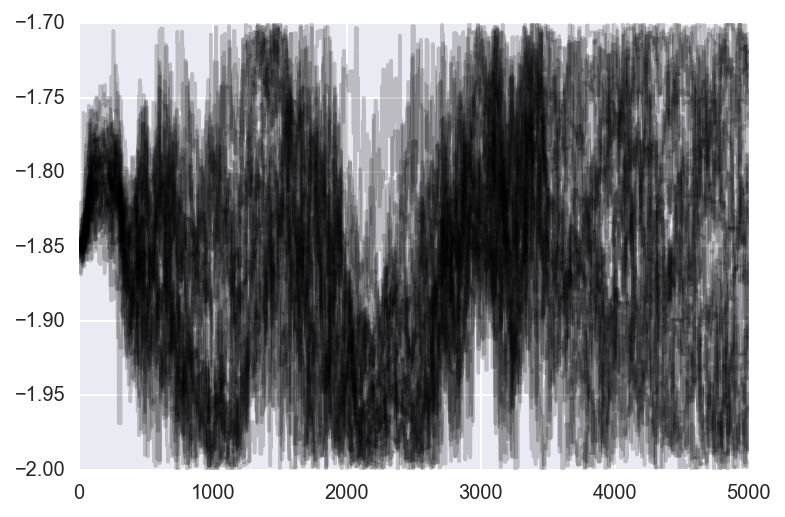

In [4]:
plt.plot(ws[:,:, 9].T, 'k-', alpha=0.2);

Much better than run01... it was not burned in enough!

In [5]:
burned = ws[:, -1000:,:]
xs, ys, zs = burned.shape
fc = burned.reshape(xs*ys, zs)

In [6]:
from sklearn.mixture import GMM #already imported if you ran the astroML code

(4.0, 8.0)

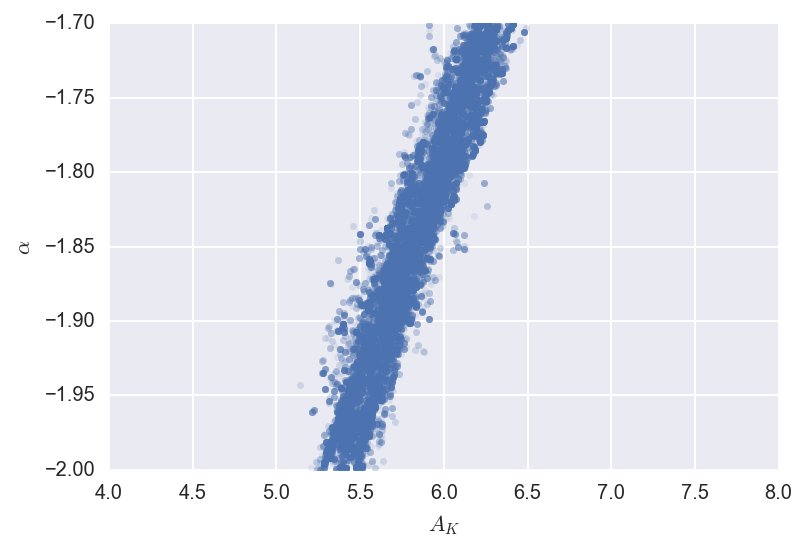

In [9]:
plt.plot(fc[:, 8], fc[:, 9], '.', alpha=0.1);
plt.ylim(-2, -1.7)
plt.xlabel('$A_K$')
plt.ylabel(r'$\alpha$')
plt.xlim(4.0, 8.0)

Let's clone that distribution.

In [10]:
X = fc[:, 8:10]

In [11]:
import matplotlib as mpl
import itertools
from scipy import linalg

In [23]:
Xgrid.shape

(2500, 2)

In [12]:
#------------------------------------------------------------
# Use a GMM to model the density and clone the points
gmm = GMM(12, 'full', min_covar=1.0e-8).fit(X)
X_new = gmm.sample(40000)

xmin = 4
xmax = 8
ymin = -2
ymax = -1.7
Xgrid = np.meshgrid(np.linspace(xmin, xmax, 50),
                    np.linspace(ymin, ymax, 50))
Xgrid = np.array(Xgrid).reshape(2, -1).T

dens = np.exp(gmm.score(Xgrid)).reshape((50, 50))

In [33]:
np.array([5.6, -1.8])[np.newaxis,:].shape

(1, 2)

In [30]:
gmm.score([5.6, -1.8])

/anaconda/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([-3.43586117])

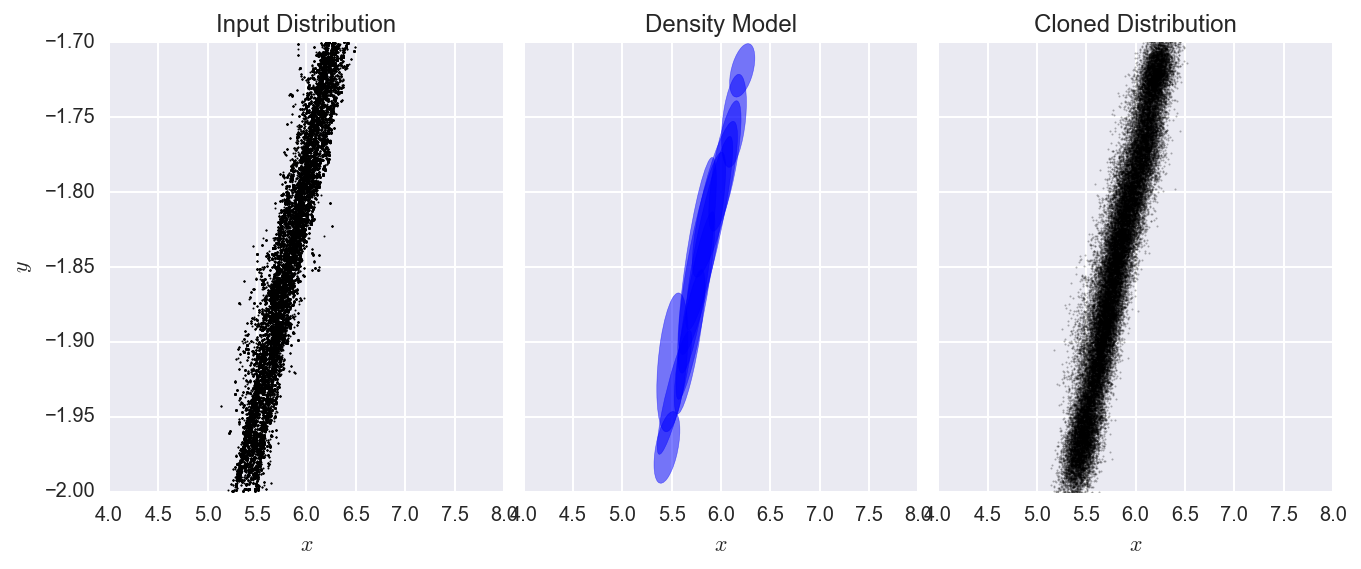

In [13]:
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.05,
                    bottom=0.12, top=0.9)

# first plot the input
ax = fig.add_subplot(131)
ax.plot(X[:, 0], X[:, 1], '.k', ms=2)

ax.set_title("Input Distribution")
ax.set_ylabel('$y$')

# next plot the gmm fit
ax = fig.add_subplot(132)
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])

# I can't get imshow to work for some reason.
#ax.pcolor(Xgrid[:, 0][:, np.newaxis], Xgrid[:, 1][:, np.newaxis], dens_lin[:, np.newaxis])

Y_, means, covariances = gmm.predict(X), gmm.means_, gmm.covars_ 
for i, (mean, covar, color) in enumerate(zip(
        means, covariances, color_iter)):
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # as the DP will not use every component it has access to
    # unless it needs it, we shouldn't plot the redundant
    # components.
    if not np.any(Y_ == i):
        continue
    #plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color='b')
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)


ax.set_title("Density Model")
ax.yaxis.set_major_formatter(plt.NullFormatter())

# next plot the cloned distribution
ax = fig.add_subplot(133)
ax.plot(X_new[:, 0], X_new[:, 1], '.k', alpha=0.3, ms=2)

ax.set_title("Cloned Distribution")
ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in fig.axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('$x$')

plt.show()

How many components to use? 
Just do an AIC or BIC analysis.  It doesn't really matter.

In [14]:
N = np.arange(1, 14)

In [18]:
def compute_GMM(N, covariance_type='full', n_iter=1000, min_covar=1.0e-8):
    models = [None for n in N]
    for i in range(len(N)):
        print(N[i])
        models[i] = GMM(n_components=N[i], n_iter=n_iter,min_covar=1.0e-8,
                        covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GMM(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

1
2
3
4
5
6
7
8
9
10
11
12
13


In [19]:
i_best = np.argmin(AIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("AIC: n_components =  %i" % N[i_best])

best fit converged: True
AIC: n_components =  13


In [20]:
i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

best fit converged: True
BIC: n_components =  13


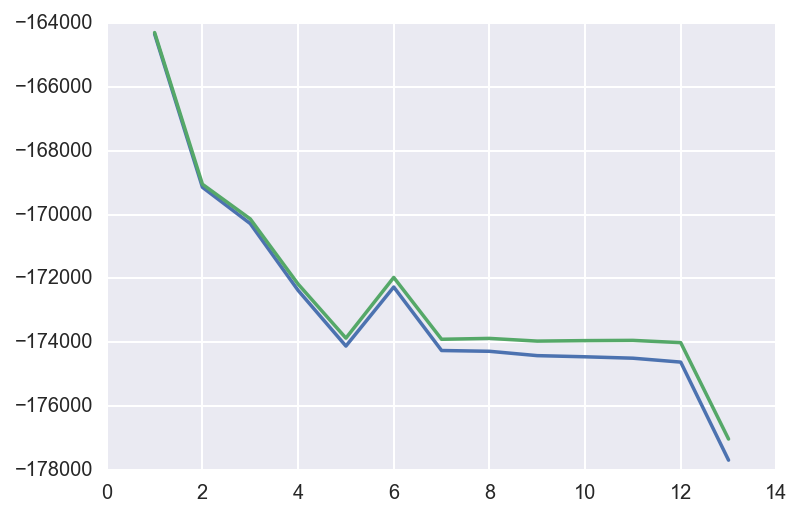

In [22]:
plt.plot(N, AIC)
plt.plot(N, BIC)

OK.